In [1]:
import os, sys, glob
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.backend import tensorflow_backend


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    return dict

In [3]:
def load_data():
    data   = []
    DIR_P2 = 'data'
    train_files = glob.glob(os.path.join(DIR_P2, 'data_batch*'))
    label_files = glob.glob(os.path.join(DIR_P2, '*.meta'))

    label_code = unpickle(label_files[0])
    print(label_code)


    for f in train_files:
        images = unpickle(f)
        filenames  = images[b'filenames']
        labels     = images[b'labels']
        images     = images[b'data']
        images     = np.reshape(images, (len(filenames), -1))
        
        for i, (f,l,imgs) in enumerate(zip(filenames, labels, images)):
            imgs    = np.reshape(imgs,[3,-1])
            top_img = imgs[0]
            top_img = np.reshape(top_img,[3,-1]).T
            top_img = np.reshape(top_img,[32,32,3])
            # eliminate 'OTHER' Class
            if l != 0: 
                data.append((f,l,top_img))
    return np.array(data)

In [4]:
import seaborn as sns
def show_data(data):
    plt.style.use('default')
    sns.set()
    df = pd.DataFrame(data[:,:2], columns=['file','label'])
    df['label'] = df['label'].astype(str)
    sns.countplot(df['label'],color="gray")


# モデル定義 resnet_v2


In [5]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.regularizers import l2
from keras.optimizers import Adam
from keras import backend as K
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v2(input_shape, depth, num_classes=9):

    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0: 
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:
                    strides = 2

            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    x = Flatten()(x)
    x = Dense(8, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
model = resnet_v2(input_shape=(32,32,3), depth=3 * 9 + 2)


In [7]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

{b'label_names': [b'OTHER', b'2L', b'L', b'M', b'S', b'2S', b'BD', b'BC', b'BS', b'C'], b'num_cases_per_batch': 1400, b'num_vis': 3072}
(7861, 3)


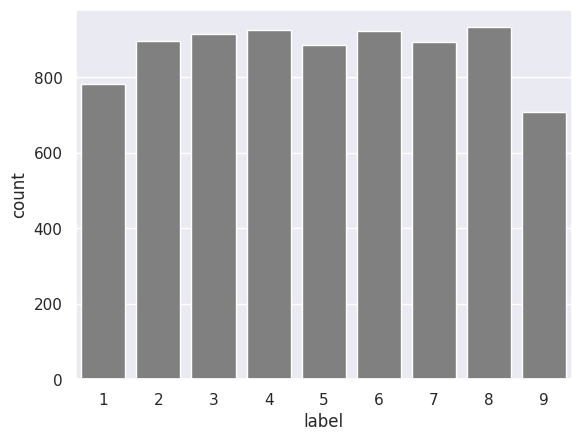

In [8]:
data = load_data()
print(data.shape)
show_data(data)

In [9]:
np.random.seed(seed=10)
np.random.shuffle(data)

test_num   = int(len(data) * 0.2)
test_data  = data[:test_num]
valid_data = data[test_num:test_num*2]
train_data = data[test_num*2:]
len(test_data),len(valid_data),len(train_data)


test_data_X  = np.stack(test_data[:,2])
test_data_y  = test_data[:,1]
valid_data_X = np.stack(valid_data[:,2])
valid_data_y = valid_data[:,1]
train_data_X = np.stack(train_data[:,2])
train_data_y = train_data[:,1]


len(train_data_y), len(valid_data_y), len(test_data_y), 

(4717, 1572, 1572)

In [10]:
model.compile(loss='mean_squared_error',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['mae', 'acc'])
model_dir  = 'models'
model_name = 'cucumber_regresser_{epoch:03d}.h5'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, model_name)


checkpoint = ModelCheckpoint(filepath=model_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)


callbacks = [checkpoint, lr_reducer, lr_scheduler]

hist = model.fit(train_data_X, train_data_y,
          batch_size=32,
          epochs=200,
          validation_data=(valid_data_X, valid_data_y),
          shuffle=True,
          callbacks=callbacks,
          verbose=1
         )


Learning rate:  0.001

Train on 4717 samples, validate on 1572 samples
Epoch 1/200
Learning rate:  0.001
4717/4717 [==============================] - 9s 2ms/step - loss: 7.0066 - mae: 1.8702 - acc: 0.1883 - val_loss: 11.2420 - val_mae: 2.9380 - val_acc: 0.0503
Epoch 2/200
Learning rate:  0.001
 224/4717 [>.............................] - ETA: 3s - loss: 2.8579 - mae: 1.1629 - acc: 0.2679

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


4717/4717 [==============================] - 4s 848us/step - loss: 2.7668 - mae: 1.1664 - acc: 0.2678 - val_loss: 8.3760 - val_mae: 2.4915 - val_acc: 0.0668
Epoch 3/200
Learning rate:  0.001
4717/4717 [==============================] - 4s 832us/step - loss: 2.4306 - mae: 1.0500 - acc: 0.3193 - val_loss: 16.5233 - val_mae: 3.7275 - val_acc: 0.0095
Epoch 4/200
Learning rate:  0.001
4717/4717 [==============================] - 4s 886us/step - loss: 2.1877 - mae: 0.9809 - acc: 0.3350 - val_loss: 2.3886 - val_mae: 1.0723 - val_acc: 0.3003
Epoch 5/200
Learning rate:  0.001
4717/4717 [==============================] - 4s 807us/step - loss: 2.0101 - mae: 0.9288 - acc: 0.3576 - val_loss: 2.7672 - val_mae: 1.1925 - val_acc: 0.2697
Epoch 6/200
Learning rate:  0.001
4717/4717 [==============================] - 4s 912us/step - loss: 1.8472 - mae: 0.8740 - acc: 0.3814 - val_loss: 4.7792 - val_mae: 1.7431 - val_acc: 0.1310
Epoch 7/200
Learning rate:  0.001
4717/4717 [==============================] -

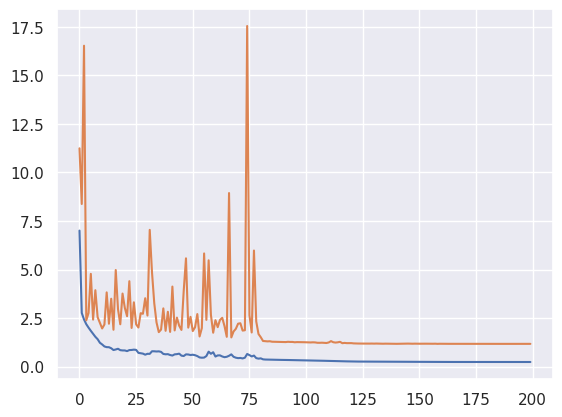

In [15]:
plt.plot(hist.epoch, hist.history['loss'])
plt.plot(hist.epoch, hist.history['val_loss'])



In [12]:
predict_y = model.predict(test_data_X)


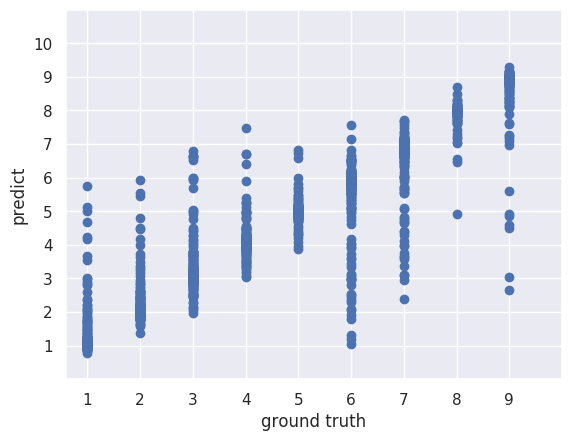

In [13]:
plt.style.use('default')
sns.set()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

indexes=[]
res_y = []
for i in range(1,10):
    index = test_data_y==i
    res_y.append(predict_y[index])


ax.scatter(test_data_y, predict_y.flatten())
ax.set_xticks(range(1,11))
ax.set_yticks(range(1,11))
ax.set_xticklabels(range(1,10))
ax.set_xlabel('ground truth')
ax.set_ylabel('predict')
ax.set_ylim(0, 11)
plt.show()

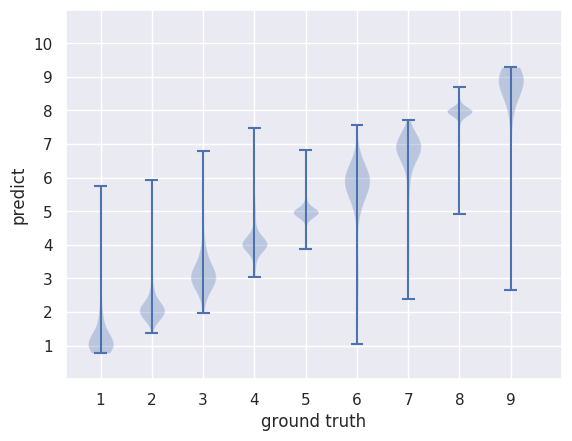

In [14]:
plt.style.use('default')
sns.set()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

indexes=[]
res_y = []
for i in range(1,10):
    index = test_data_y==i
    res_y.append(predict_y[index])


ax.violinplot(res_y)
ax.set_xticks(range(1,11))
ax.set_yticks(range(1,11))
ax.set_xticklabels(range(1,10))
ax.set_xlabel('ground truth')
ax.set_ylabel('predict')
ax.set_ylim(0, 11)
plt.show()